In [1]:
#| default_exp chewc

In [2]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid

class ChewC:
    def __init___(self):
        self.trait = None
        self.genome = None
        self.population = None

        
class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance):
        #store attributes
        self.target_mean = target_mean
        self.target_variance = target_variance
        
        #sample initial random effects
        random_effects = np.random.randn(g.n_chr, g.n_loci)
        #calculate the founder_population mean and var given these effects
        founder_scores = np.array([random_effects @ x.haplotype for x in population.individuals])
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        #scale the random effects to match our target variance
        scaling_factors = np.sqrt(self.target_variance / founder_var)
        random_effects *= scaling_factors
        self.effects = random_effects
        
        self.intercept = founder_mean - target_mean
        
    def __matmul__(self,other):
        if isinstance(other,Individual):
            return self.effects * other.haplotype + self.intercept
        elif isinstance(other, Population):
            return np.sum(np.array([self @ ind + self.intercept for ind in other.individuals]), axis=(1,2))

        
class Population:
    def __init__(self, genome, size=None):
        self.genome = genome
        self.ploidy = 2
        if size:
            self.size = size
            self.individuals = self._create_initial_population()
        else:
            pass

    def _create_initial_population(self):
        """Create an initial population of founder individuals."""
        return [Individual(self.genome) for _ in range(self.size)]
    
    def get_haplo(self):
        return np.array([x.haplotype for x in self.individuals])
    
    def get_pheno(self):
        return np.array([x.fitness for x in self.individuals])
    
    def __getitem__(self, index):
        # Convert numpy arrays to lists for indexing
        if isinstance(index, np.ndarray):
            index = index.tolist()
        # Handle list of indices
        if isinstance(index, list):
            return [self.individuals[i] for i in index]
        # Handle single index
        return self.individuals[index]
    
    def __repr__(self):
        return f'Population of size: {self.size}'
    

class Individual:
    def __init__(self, genome,haplotype=None, mother = None, father = None, descendants = 0, source='founder', chewc=None):
        self.genome = genome  # must be Genome class
        self.haplotype = None
        self.source = source  # 'founder', 'cross', 'self', 'dh'
        self.descendents = []
        self.fitness = 0
        self.mother, self.father = mother, father

        # Logic for setting haplotype,mother,father
        if self.source == 'founder':
            self.haplotype= self._generate_random_haplotype()
        else:
            self.haplotype = haplotype
            
        self.make_id()
            
    def __repr__(self):
        return f'Individual with haplotype shape: {self.haplotype.shape}'
    
    def make_id(self):self.id = uuid.uuid4().hex


    def _generate_random_haplotype(self):
        """Generate a random haplotype for the individual."""
        return np.random.choice([0, 1], size=(self.genome.ploidy, self.genome.n_chr, self.genome.n_loci))
         

# to do move this in another module
@patch
def gamete(self:Individual):
    haplotypes = self.haplotype
    def shuffle_chr(chromosome_pair):
        """
        Perform crossover on a pair of chromosomes.

        Parameters:
        chromosome_pair (list): A list of two equal length lists representing chromosomes.

        Returns:
        list: A new chromosome formed by shuffling the given chromosome pair.
        """
        # Ensure the chromosome pair contains two chromosomes of equal length
        assert len(chromosome_pair) == 2
        assert len(chromosome_pair[0]) == len(chromosome_pair[1])

        # Number of crossover points, sampled from a Poisson distribution with λ=1.3
        n_crossover = np.random.poisson(1.3)

        # Determine crossover locations, sampled without replacement from chromosome length
        chromosome_length = len(chromosome_pair[0])
        crossover_locs = np.sort(np.random.choice(chromosome_length, n_crossover, replace=False))

        # Initialize the new chromosome and set the current chromosome to the first one
        new_chromosome = []
        current_chr = 0

        # Perform crossover by alternating segments between the two chromosomes
        last_loc = 0
        for loc in crossover_locs:
            new_chromosome.extend(chromosome_pair[current_chr][last_loc:loc])
            current_chr = 1 - current_chr  # Switch to the other chromosome
            last_loc = loc

        # Append the remaining segment
        new_chromosome.extend(chromosome_pair[current_chr][last_loc:])
        return np.array(new_chromosome)

    # Initialize an empty array to store the shuffled chromosomes
    shuffled_haplotypes = np.zeros_like(haplotypes)
    ploidy, n_chr, n_loci = chewc.genome.shape
    # Iterate over each chromosome and apply the shuffle_chr function
    for i in range(haplotypes.shape[1]):  # Iterate over the chromosomes
        chromosome_pair = haplotypes[:, i, :]  # Extract the chromosome pair (2, 77)
        shuffled_chromosome = shuffle_chr(chromosome_pair)  # Shuffle the chromosome pair    
        shuffled_haplotypes[:, i, :] = np.array(shuffled_chromosome).reshape(1, n_loci)  # Store the shuffled chromosome
    return shuffled_haplotypes[0,:,:]

class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance):
        #store attributes
        self.target_mean = target_mean
        self.target_variance = target_variance
        
        #sample initial random effects
        initial_effects = np.random.randn(g.n_chr * g.n_loci)
        initial_effects -= initial_effects.mean()
        #calculate the founder_population mean and var given these effects
        pop_scores = np.sum(founder_population.get_haplo(),axis=1).reshape(founder_population.size, g.n_chr*g.n_loci)
        founder_scores = np.sum(initial_effects*pop_scores,axis=1)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = np.sqrt(self.target_variance / founder_var)
        initial_effects *= scaling_factors
        scaled_effects = initial_effects # ADDS A FIXED EFFECT SOMEHOW????
        self.effects = scaled_effects
        self.intercept = target_mean - founder_mean

@patch
def x(self:Individual, partner):
    if isinstance(partner,Individual):
        source = 'cross'
        progeny_haplo = np.vstack((self.gamete(), partner.gamete()))
        
        progeny = Individual(self.genome, progeny_haplo, self.id, partner.id,source=source, chewc = chewc)
        return progeny
    
@patch
def __matmul__(self:Trait,other):
    if isinstance(other,Individual):
#             print(f' intercept {self.intercept}')
        breeding_value = self.effects * np.sum(other.haplotype,axis=0).flatten()
        return breeding_value
    else:
        print('ffff')
@patch
def phenotype(self:Individual, h2, environmental_variance):
    """
    Calculate the phenotype for the individual.

    Args:
        h2 (float): Heritability of the trait.
        environmental_variance (float): The calculated environmental variance for the population.
    """
    breeding_value = chewc.trait @ self
    phenotype_value = breeding_value + np.random.normal(0, np.sqrt(environmental_variance))
    self.fitness = np.sum(phenotype_value)
    
@patch
def trial(self:Population, h2):
    """
    Simulate phenotypes for all individuals in the population.

    Args:
        h2 (float): Heritability of the trait.
    """
    # 1. Calculate environmental variance at the population level
    population_genetic_variance = np.var(chewc.population.get_pheno(), ddof=1)
    environmental_variance = (1 - h2) / h2 * population_genetic_variance

    # 2. Phenotype each individual, passing the environmental variance
    for individual in self.individuals:
        individual.phenotype(h2, environmental_variance) 

    def __getitem__(self, index):
        return self.individuals[index]

    def __repr__(self):
        return f'Population of size: {self.size}'

@patch
def truncation(self:Population, top_percent):
    """
    Returns the indexes of phenotypes in the top percent.

    Args:
        top_percent (float): The top percentage of individuals to select (0 < top_percent <= 100).
    """
    # Ensure the top_percent is within the valid range
    if top_percent <= 0 or top_percent > 100:
        raise ValueError("top_percent must be between 0 and 100")

    # Calculate the number of individuals to select
    num_to_select = int(population.size * top_percent / 100)

    # Get the phenotypes of all individuals
    phenotypes = self.get_pheno()
    assert phenotypes.sum() != 0, 'no phenotypes present'
#     print(phenotypes)

    # Get the indices that would sort the array in descending order
    sorted_indices = np.argsort(phenotypes)[::-1]

    # Select the top individuals based on the sorted indices
    top_indices = sorted_indices[:num_to_select]

    return self[top_indices]


#Define the Simulation Parameters
g = Genome(3, 1000)
population = Population(g, size=999)
trait = Trait(g, population,5,1000)

#Plug them into ChewC
chewc = ChewC()
chewc.trait = trait
chewc.population = population
chewc.genome = g

In [3]:
chewc.population.trial(1)

In [4]:
chewc.population[0].fitness

26.08365894945355

(array([  8.,  45., 113., 223., 267., 206.,  93.,  37.,   6.,   1.]),
 array([-93.5297071 , -72.15439126, -50.77907542, -29.40375958,
         -8.02844374,  13.3468721 ,  34.72218794,  56.09750378,
         77.47281962,  98.84813546, 120.2234513 ]),
 <BarContainer object of 10 artists>)

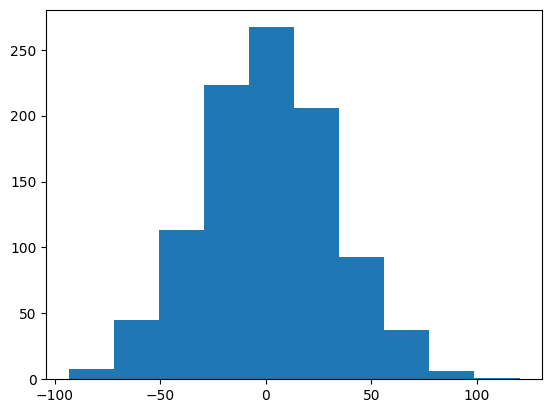

In [5]:

plt.hist(chewc.population.get_pheno())

In [6]:
# %%timeit
# chewc.population[0].gamete()

In [7]:
# %%timeit
# chewc.population[0].x(chewc.population[1])

In [8]:
#| hide
import nbdev; nbdev.nbdev_export()

In [9]:
def randomize_pairing(input_array):
    # Convert input array to numpy array if it isn't already
    array = np.array(input_array)
    
    # Shuffle the array
    np.random.shuffle(array)
    
    # Pair the elements
    n = len(array)
    if n % 2 != 0:
        # If the length of the array is odd, add a None to make it even
        array = np.append(array, None)
        n += 1
    
    pairs = [(array[i], array[i + 1]) for i in range(0, n, 2)]
    
    return pairs

In [10]:
chewc.population[4:6]

[Individual with haplotype shape: (2, 3, 1000),
 Individual with haplotype shape: (2, 3, 1000)]

In [11]:
indexes = chewc.population.truncation(1)

In [12]:
indexes

[Individual with haplotype shape: (2, 3, 1000),
 Individual with haplotype shape: (2, 3, 1000),
 Individual with haplotype shape: (2, 3, 1000),
 Individual with haplotype shape: (2, 3, 1000),
 Individual with haplotype shape: (2, 3, 1000),
 Individual with haplotype shape: (2, 3, 1000),
 Individual with haplotype shape: (2, 3, 1000),
 Individual with haplotype shape: (2, 3, 1000),
 Individual with haplotype shape: (2, 3, 1000)]